In [1]:
import os
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry.pointcloud import PointCloud
from anndata import AnnData
from sklearn.model_selection import train_test_split

from moscot.problems.time import TemporalNeuralProblem
from moscot.datasets import simulate_data

/dss/dsshome1/06/di93vel/.conda/envs/moscot_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Map organoid data to primary tissue data

First, we load the organoid and primary tissue data. We select n cells at random from both the organoid and primary tissue data to reduce the amount of memory required by the OT algorithm, which computes an n by n matrix. Then, we concatenate the randomly selected organoid and primary tissue data. We create a condition column ('condition_col') to keep track of the origin of each datapoint. Then, we perform the OT mapping. Note that the mapping happens in PCA space. After we have mapped our organoid cells, we must project the mapped embeddings back in the original feature space.

In [2]:
wd = "/mnt/atlas_building"
organoid = sc.read(os.path.join(wd, "intestine_scpoli_integration.h5ad"))

In [3]:
organoid

AnnData object with n_obs × n_vars = 359006 × 1807
    obs: 'sort_batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'level_1', 'level_2', 'level_3', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'batch', 'publication', 'leiden', 'sample_name', 'tissue', 'derive', 'detail_tissue', 'time', 'main_cells', 'protocol', 'tech', 'tech_detail', 'cell_name', 'Mapped_fetal_organ', 'Mapped_Major_cell_type', 'Mapped_Cell_type', 'RSSUMAP_1', 'RSSUMAP_2'
    uns: 'leiden', 'level_1_colors', 'level_2_colors', 'level_3_colors', 'log1p', 'neighbors', 'publication_colors', 'umap'
    obsm: 'X_scPoli', 'X_umap', 'X_umap_min'
    layers: 'ambiguous', 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [4]:
print(np.max(organoid.X))
print(np.min(organoid.X))

8.754192
0.0


In [5]:
condition_col = "condition"
base_condition = "organoid"
organoid.obs[condition_col] = base_condition

In [6]:
# download data from https://www.gutcellatlas.org/
# primary = sc.read(os.path.join(wd, "Full_obj_raw_counts_nosoupx_v2.h5ad"))
primary = sc.read(os.path.join(wd, "Full_obj_log_counts_soupx_v2.h5ad"))

In [7]:
primary

AnnData object with n_obs × n_vars = 428469 × 30535
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Gender', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'Integrated_05'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'Integrated_colors', 'category2_colors', 'category_colors', "dendrogram_['Integrated']", "dendrogram_['Integrated_05']", 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'

In [8]:
print(np.max(primary.X))
print(np.min(primary.X))

8.972117
0.0


In [9]:
alternate_condition = "primary"
primary.obs[condition_col] = alternate_condition

In [10]:
seed = 42
ncells = 10000

# select n cells at random
rng = np.random.default_rng(seed)
choice_source = rng.choice(np.arange(len(organoid)), ncells, replace=False)
choice_target = rng.choice(np.arange(len(primary)), ncells, replace=False)

In [11]:
# concatenate randomly selected organoid and primary tissue data points
adata = anndata.concat([organoid[choice_source], primary[choice_target]])

/dss/dsshome1/06/di93vel/.conda/envs/moscot_venv/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [12]:
# create a dictionary to map categorical condition values to numerical values
cat2num = {
     base_condition: 0,
     alternate_condition: 1,
}

# add a new ".obs" column called "condition_numerical" by mapping categorical to numerical values using pandas' "map" function
adata.obs['condition_numerical'] = adata.obs[condition_col].map(cat2num)

In [13]:
adata

AnnData object with n_obs × n_vars = 20000 × 1767
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'condition', 'condition_numerical'
    obsm: 'X_umap'

In [14]:
adata.var_names

Index(['PYY', 'CHGA', 'GUCA2B', 'GUCA2A', 'GCG', 'SST', 'CCL4', 'REG4', 'CHGB',
       'CCL21',
       ...
       'LINC00636', 'LCE5A', 'SMAD1', 'CTHRC1', 'TMEM158', 'FRMPD2', 'GCLC',
       'PLCZ1', 'ASTN2-AS1', 'HEPHL1'],
      dtype='object', length=1767)

In [15]:
center = False
sc.tl.pca(adata, zero_center=center)

/dss/dsshome1/06/di93vel/.conda/envs/moscot_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


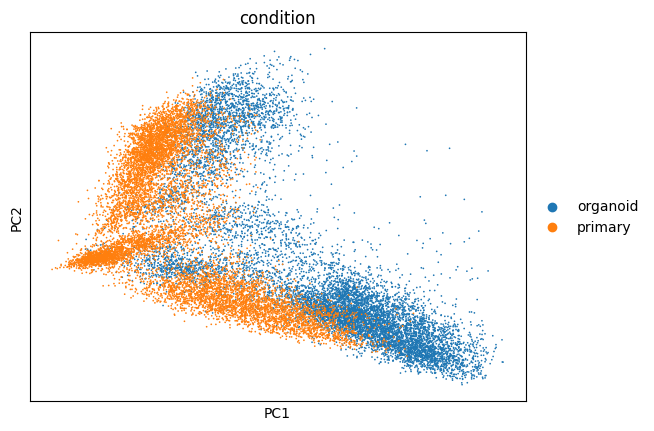

In [16]:
# PCA before mapping
sc.pl.pca(adata, color='condition')

In [17]:
tnp = TemporalNeuralProblem(adata)
# time_key must be NUMERICAL
# note that we perform the mapping in the PCA space
tnp = tnp.prepare(time_key="condition_numerical", joint_attr="X_pca", policy="explicit", subset=[(0,1)])

In [18]:
# tau_a & tau_b are the imbalance parameters for the source and target distributions, respectively, and can be tuned depending on dataset
# 1.0 is standard - lowering it introduces unbalancedness
tnp = tnp.solve(
        iterations=25000,
        batch_size=1024,
        valid_freq=250,
        log_freq=10,
        patience=100,
        pretrain=True,
        train_size=1.0,
        tau_a=1.0,
        tau_b=1.0)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(10000, 10000)].                          


100%|██████████| 25000/25000 [13:13<00:00, 31.51it/s]


In [19]:
tnp[(0,1)]

BirthDeathNeuralProblem[stage='solved', shape=(10000, 10000)]

In [20]:
# adjust for time pair
solution = tnp[(0,1)].solution
# best_loss should be lower than sink_dist
print(solution)

NeuralOutput[predicted_cost=233.152, best_loss=58.338, sink_dist=221.206]


In [21]:
# currently using best forward/push model
x = jnp.array(adata[adata.obs["condition_numerical"] == 0].obsm["X_pca"].toarray())
y = jnp.array(adata[adata.obs["condition_numerical"] == 1].obsm["X_pca"].toarray())
# mapping organoid cells to primary tissue cells
pred_y = solution.push(x)
# mapping primary tissue cells to organoid cells
pred_x = solution.pull(y)

In [22]:
print(x.shape)
print(y.shape)
print(pred_y.shape)
print(pred_x.shape)

(10000, 50)
(10000, 50)
(10000, 50)
(10000, 50)


In [23]:
adata_alternate = adata[adata.obs[condition_col] == alternate_condition]
mu = np.mean(adata_alternate.X, axis=0)
mu

matrix([[0.01093554, 0.03866376, 0.10820528, ..., 0.        , 0.00042062,
         0.00011916]], dtype=float32)

In [24]:
evecs = adata_alternate.varm['PCs']
pc_scores = pred_y

In [25]:
print(evecs.shape)
print(pc_scores.shape)

(1767, 50)
(10000, 50)


In [26]:
# project data back in the original feature space
# https://stats.stackexchange.com/questions/229092/how-to-reverse-pca-and-reconstruct-original-variables-from-several-principal-com

if center:
    Y = np.dot(pc_scores, evecs.T) + mu  # zero_center == True
else:
    print('False')
    Y = np.dot(pc_scores, evecs.T)       # zero_center == False

Y.shape

False


(10000, 1767)

In [27]:
adata_pred = AnnData(Y)
adata_pred.obsm["X_pca"] = pc_scores
adata_pred.varm["PCs"] = evecs
adata_pred.obs["condition"] = "predicted"
adata_pred.var.index = adata.var.index

In [28]:
np.mean(adata_pred.X, axis=0)

array([ 2.0465134e-02,  1.9575216e-02,  9.7196080e-02, ...,
       -1.4657082e-05,  5.3972722e-04,  7.7797020e-05], dtype=float32)

/dss/dsshome1/06/di93vel/.conda/envs/moscot_venv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


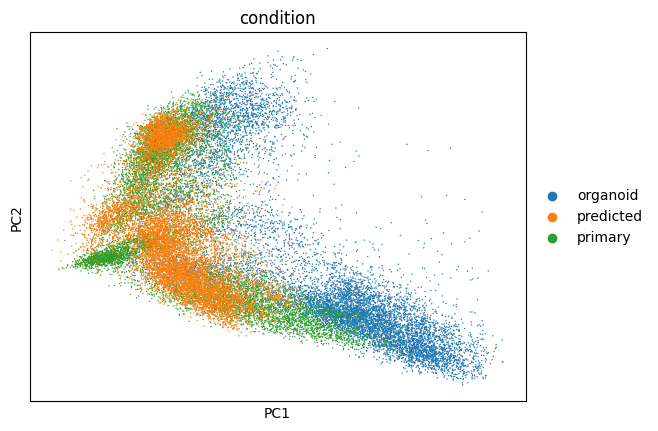

In [29]:
adata_c = anndata.concat([adata, adata_pred])
# PCA after mapping
sc.pl.pca(adata_c, color="condition")

## Transfer primary tissue cell type annotation to mapped organoid cells

In [30]:
target = adata[adata.obs["condition_numerical"] == 1]
labels = primary[choice_target].obs['category'] # cell type annotation

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)  # you can adjust the value of k as per your requirement
knn.fit(target.obsm["X_pca"], labels)

mapped_points = pred_y
predicted_labels = knn.predict(mapped_points)

## Plot label distributions

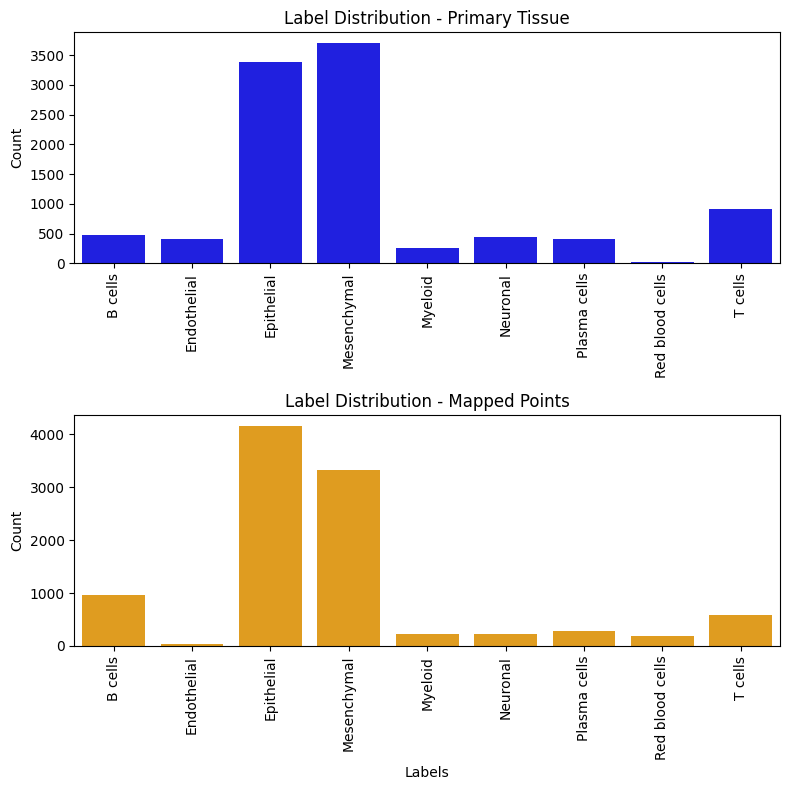

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# get the unique labels and their respective counts
unique_labels, label_counts = np.unique(labels, return_counts=True)
_, predicted_label_counts = np.unique(predicted_labels, return_counts=True)

# create separate bar plots for primary tissue labels and predicted labels
fig, axes = plt.subplots(2, 1, figsize=(8, 8))

# plot histogram for primary tissue labels
sns.barplot(x=unique_labels, y=label_counts, color='blue', ax=axes[0])
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution - Primary Tissue')

# plot histogram for predicted labels
sns.barplot(x=unique_labels, y=predicted_label_counts, color='orange', ax=axes[1])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Count')
axes[1].set_title('Label Distribution - Mapped Points')

# rotate x-axis labels by 90 degrees
axes[0].set_xticklabels(unique_labels, rotation=90)
axes[1].set_xticklabels(unique_labels, rotation=90)

# adjust spacing between subplots
plt.tight_layout()

# show the plot
plt.show()


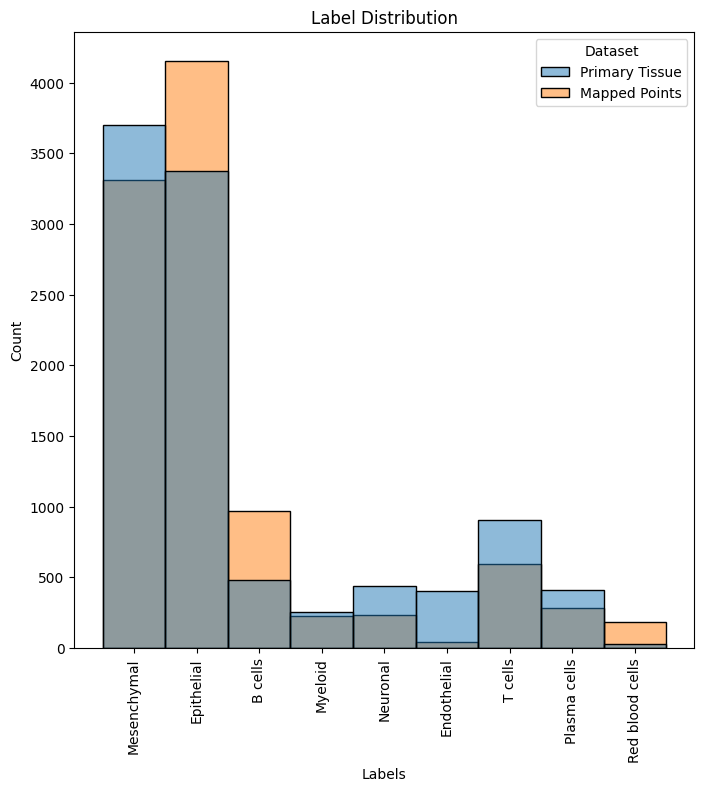

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

# combine the labels into a single array
all_labels = np.concatenate((labels, predicted_labels))

# create a dataframe with labels and dataset information
data = {'Labels': all_labels, 'Dataset': ['Primary Tissue'] * len(labels) + ['Mapped Points'] * len(predicted_labels)}
df = pd.DataFrame(data)

# create histogram with overlaid datasets
sns.histplot(data=df, x='Labels', hue='Dataset', multiple='layer', ax=ax)

ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Label Distribution')

# rotate x-axis labels by 90 degrees
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# show the plot
plt.show()

In [33]:
adata_pred.obsm["X_pca"] = np.array(adata_pred.obsm["X_pca"])

In [34]:
# save predictions
# adata_pred.write(wd + "neuralot_zerocenteringFalse.h5ad")